In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Carregar os arquivos
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Definir o limite de 50% para exclusão de colunas
threshold = 0.5

# Remover colunas com mais de 50% de valores ausentes em ambos os datasets
train_df = train_df.loc[:, train_df.isnull().mean() <= threshold]

# Alinhar as colunas entre treino e teste (manter apenas colunas comuns)
common_columns = train_df.columns.intersection(test_df.columns)
train_df = train_df[common_columns]
test_df = test_df[common_columns]

# Calcular a mediana das colunas do conjunto de treino
train_medians = train_df.median()

# Preencher os valores ausentes no conjunto de treino usando a mediana calculada
train_df.fillna(train_medians, inplace=True)

# Preencher os valores ausentes no conjunto de teste usando a mediana do conjunto de treino
test_df.fillna(train_medians, inplace=True)

# Função para substituir outliers pela mediana
def replace_outliers_with_median(df, lower_quantile=0.25, upper_quantile=0.75, factor=1.5):
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        median = df[col].median()
        
        # Substituir os valores que estão fora dos limites pelo valor da mediana
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median, df[col])
    return df

# Aplicar a função de substituição dos outliers nos dados de treino e teste
X_train = replace_outliers_with_median(train_df.drop('y', axis=1))
y_train = train_df['y']
X_test = replace_outliers_with_median(test_df.drop('y', axis=1))
y_test = test_df['y']

# Escalonar os dados usando StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Converter os arrays escalonados de volta para DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)


In [4]:
# Selecionar 10% dos dados de treino mantendo a proporção das classes na coluna 'y'
X_train_scaled, _, y_train, _ = train_test_split(
    X_train_scaled, y_train, 
    test_size=0.9,  # Retém 10% dos dados
    stratify=y_train,  # Mantém a proporção das classes
    random_state=42
)

# Exibir o número de amostras em cada conjunto e a distribuição das classes
print("Amostra de treino - Distribuição de classes:")
print(y_train.value_counts(normalize=True))

print("\nAmostra de teste - Distribuição de classes:")
print(y_test.value_counts(normalize=True))

Amostra de treino - Distribuição de classes:
1    0.856213
0    0.143787
Name: y, dtype: float64

Amostra de teste - Distribuição de classes:
1    0.777778
0    0.222222
Name: y, dtype: float64



Acurácia do modelo com kernel polinomial: 0.86

Relatório de classificação para kernel polinomial:
              precision    recall  f1-score   support

           0       0.88      0.00      0.01      2186
           1       0.86      1.00      0.92     13017

    accuracy                           0.86     15203
   macro avg       0.87      0.50      0.46     15203
weighted avg       0.86      0.86      0.79     15203


Matriz de confusão para kernel polinomial:
[[    7  2179]
 [    1 13016]]


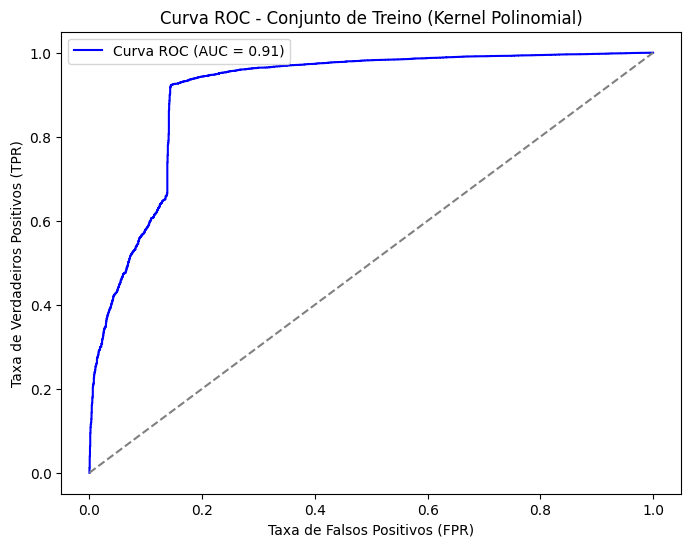

In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# Treinamento do SVM com kernel polinomial e cálculo de probabilidades
svm_poly = SVC(kernel='poly', C=0.1, gamma='auto', probability=True, random_state=42)
svm_poly.fit(X_train_scaled, y_train.values.ravel())

# Fazer previsões no conjunto de treino
y_pred_poly = svm_poly.predict(X_train_scaled)

# Avaliar a acurácia do modelo
accuracy = accuracy_score(y_train, y_pred_poly)
print(f"\nAcurácia do modelo com kernel polinomial: {accuracy:.2f}")

# Avaliar o desempenho do modelo com kernel polinomial
print("\nRelatório de classificação para kernel polinomial:")
print(classification_report(y_train, y_pred_poly))

# Matriz de confusão
print("\nMatriz de confusão para kernel polinomial:")
print(confusion_matrix(y_train, y_pred_poly))

# Calcular e plotar a curva ROC AUC
y_train_proba = svm_poly.predict_proba(X_train_scaled)[:, 1]
roc_auc = roc_auc_score(y_train, y_train_proba)
fpr, tpr, thresholds = roc_curve(y_train, y_train_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Treino (Kernel Polinomial)")
plt.legend()
plt.show()



Acurácia do modelo com kernel polinomial no conjunto de teste: 0.78

Relatório de classificação para kernel polinomial (conjunto de teste):
              precision    recall  f1-score   support

           0       0.65      0.05      0.09      2388
           1       0.78      0.99      0.88      8358

    accuracy                           0.78     10746
   macro avg       0.72      0.52      0.48     10746
weighted avg       0.75      0.78      0.70     10746


Matriz de confusão para kernel polinomial (conjunto de teste):
[[ 111 2277]
 [  60 8298]]


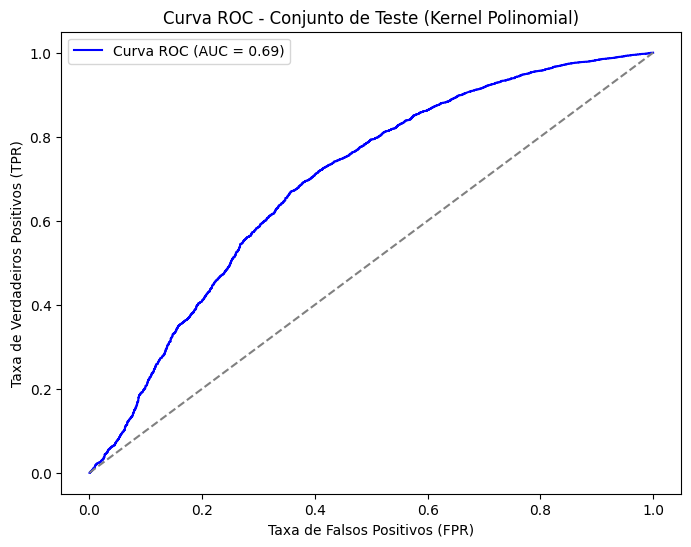

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

# Fazer previsões no conjunto de teste
y_test_pred_poly = svm_poly.predict(X_test_scaled)

# Calcular a acurácia do modelo no conjunto de teste
accuracy = accuracy_score(y_test, y_test_pred_poly)
print(f"\nAcurácia do modelo com kernel polinomial no conjunto de teste: {accuracy:.2f}")

# Avaliar o desempenho do modelo no conjunto de teste com kernel polinomial
print("\nRelatório de classificação para kernel polinomial (conjunto de teste):")
print(classification_report(y_test, y_test_pred_poly))

# Matriz de confusão para o conjunto de teste
print("\nMatriz de confusão para kernel polinomial (conjunto de teste):")
print(confusion_matrix(y_test, y_test_pred_poly))

# Calcular e plotar a curva ROC AUC
y_test_proba = svm_poly.predict_proba(X_test_scaled)[:, 1]  # Probabilidade da classe positiva
roc_auc = roc_auc_score(y_test, y_test_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.title("Curva ROC - Conjunto de Teste (Kernel Polinomial)")
plt.legend()
plt.show()
